In [1]:
import random
import math
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from scipy.optimize import minimize
from scipy.stats import gamma, norm
import seaborn as sns
import time

from functools import partial

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
N = int(1e5)  # MC iterations
def _r(x): return np.round(x, 2)
def _CI(mu, std, n=1, z=1): return mu + (z/np.sqrt(n)) * np.array([-std, std])

# Generating Random Variables

Given: A sequence $U_1, U_2, \dots$ of iid uniform (0, 1) random variables
Goal: A sequence $X_1, X_2, \dots$ of iid random variables with **cumulative distribution function** $F(·)$.

## Method 1: Inversion

Note that the function $F(·)$ is non-decreasing. Such a non-decreasing function possesses a generalized function inverse, given by:
$$F^{-1}(x) = \text{inf} \{ y : F(y) \geq x \}$$
or in  other words, $x$ is the quantile s.t. when we pass $y$ through the cdf we get a probability $\geq x$. \\
If F is continuous and strictly increasing, the generalized inverse is a function for which:
$$F(F^{-1}(x)) = F^{-1}(F(x)) = x$$


### Example 1: exponential distribution.

The exponential distribution with parameter $\lambda$ (rate, inverse scale) has inverse cdf (or quantile function) equal to:
$$F^{-1} = -\frac{ln(1 - U)}{\lambda} = -\frac{ln(U)}{\lambda}$$ 
Let's generate samples from $X \sim Exp(2)$.

In [3]:
def exp_quantile(U, lambd=1): return -np.log(U) / lambd

lambd = 2
U = np.random.uniform(size=N)
X = np.fromiter(map(partial(exp_quantile, lambd=lambd), U),
                dtype=float)

print(np.mean(X))
print(np.var(X))

0.5020219474957872
0.2507460677287859


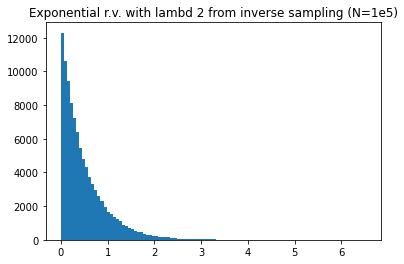

In [4]:
plt.hist(X, bins=100)
plt.title('Exponential r.v. with lambd 2 from inverse sampling (N=1e5)') 
plt.show()

In [5]:
X_np = np.random.exponential(scale=1/lambd, size=N)

print(np.mean(X_np))
print(np.var(X_np))

0.5016825197189847
0.24885135367313185


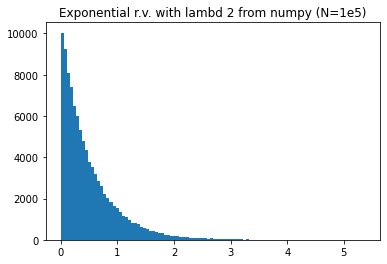

In [6]:
plt.hist(X_np, bins=100)
plt.title('Exponential r.v. with lambd 2 from numpy (N=1e5)')
plt.show()

## Method 2: Acceptance-Rejection

F has a probability density function
f(x).
The basic idea is to find an alternative probability distribution G, with density function g(x),
from which we already have an efficient algorithm for generating from (e.g., inverse transform
method), but also such that the function g(x) is “close” to f(x). In particular, we
assume that the ratio f(x)/g(x) is bounded by a constant $c > 0$:
$$\text{sup}_x \frac{f(x)}{g(x)} \leq c$$
(And
in practice we would want c as close to 1 as possible.)

Here then is the algorithm for generating X distributed as F:
- Generate rv Y from G
- Generate U
- If $$U \leq \frac{f(Y)}{c \cdot g(Y)}$$ accept (X = Y).


In the end we obtain our X as having the conditional distribution of a Y given that the
event 
$$U \leq \frac{f(Y)}{c \cdot g(Y)}$$
occurs


### Example: Normal distribution

Goal: generate $X \sim N(\mu, \sigma^2)$. \\
We know that: $X = \mu + \sigma Z$ where $Z \sim N(0, 1)$. \\
Note that if we can generate from the absolute value, $|Z|$, then by symmetry we can obtain our
$Z$ by independently generating a rv $S$ (for sign) that is $\pm 1$ with probability 1/2 and setting $Z = S|Z|$.

So, $|Z|$ is the target rv with density:
$$f_{|Z|} = \frac{2}{\sqrt{2 \pi}} e^{-x^2 / 2}, \qquad x \geq 0.$$

For the alternative method, choose $g(x) = e^{-x}, \quad x \geq 0$, i.e. exponential density with $\lambda = 1$.

Now we have to compute the bound $c$ of the ratio of the two densites. To do that, compute the ration, take the derivative and set to zero. We find that:
$$c = \sqrt{2e / \pi}$$
so $$\frac{f(y)}{c \cdot g(y)} = e^{-\frac{1}{2}(y-1)^2}$$

We are now ready to generate $Z \sim N(0,1)$!


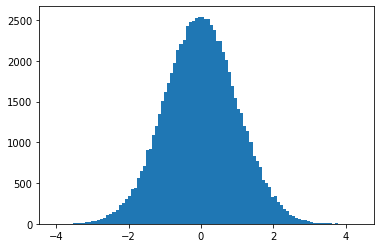

In [7]:
Z = []
for _ in range(N):
  U_1, U_2, U_3 = np.random.uniform(), np.random.uniform(), np.random.uniform()
  Y = exp_quantile(U_1)
  if U_2 <= np.exp(-0.5 * (Y - 1)**2):
     Z.append(Y) if U_3 <= 0.5 else Z.append(-Y)

plt.hist(Z, bins=100); plt.show()

Improvement. Note that:

$$U \leq e^{-\frac{1}{2} \cdot (Y - 1)^2)}$$
$$log(U) \leq -\frac{1}{2} \cdot (Y - 1)^2$$
$$-log(U) \geq \frac{1}{2} \cdot (Y - 1)^2$$

where $-log(U)$ is exponential with $\lambda = 1$. \\
The updated algo is:



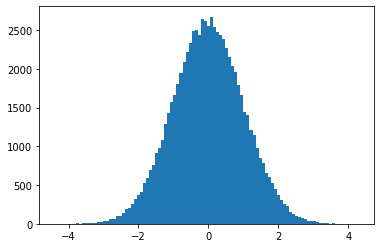

In [8]:
Z = []
for _ in range(N):
  U_1, U_2, U_3 = np.random.uniform(), np.random.uniform(), np.random.uniform()
  Y_1, Y_2 = exp_quantile(U_1), exp_quantile(U_2)
  if Y_2 >= (Y_1 - 1)**2 / 2:
    Z.append(Y_1) if U_3 <= 0.5 else Z.append(-Y_1)
      
plt.hist(Z, bins=100); plt.show()